In [1]:
import pandas as pd 
import numpy as np 
import networkx as nx 
import json 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
import tqdm
import pickle

In [ ]:
G = nx.read_graphml('../data/clean/byuser.graphml',node_type=int)
print(len(G),len(G.edges))

In [ ]:
for node in list(G.nodes)[:3]: print(node,G.nodes[node])
for node in list(G.edges)[:3]: print(node,G.edges[node])

In [4]:
df = pd.read_csv('../data/raw/geotuscany.csv', index_col=0)
df.head()

,position,name,city,menu,link,score,N_reviews,price,Name,Province,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,lucca,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,551,Acino Bianco,Marina di Massa,False,/Restaurant_Review-g194814-d12843022-Reviews-A...,4.5,92,2.5,Acino Bianco,massacarrara,...,44.004616,10.115488,Italian,Dinner,"Vegetarian Friendly, Gluten Free Options",yEU_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g194814-d12843022-Reviews-A...,0,NaN
2,308,El Artista Ristorante Argentino,Massa,False,/Restaurant_Review-g660766-d17543924-Reviews-E...,4.5,78,2.5,El Artista Ristorante Argentino,massacarrara,...,44.041000,10.124396,"Barbecue, Argentinean, Steakhouse","Dinner, Lunch",NaN,U0P_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g660766-d17543924-Reviews-E...,0,NaN
3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,florence,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
4,1499,Beach Bar @PuntAla,Punta Ala,False,/Restaurant_Review-g194871-d19315573-Reviews-B...,2.5,2,1.0,Beach Bar @PuntAla,grosseto,...,42.841410,10.775602,"Italian, Mediterranean","Lunch, Brunch, Drinks",NaN,32Q_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194871-d19315573-Reviews-B...,1,NaN


In [5]:
print(nx.dijkstra_path(G,3,4))
print(nx.dijkstra_path(G,3,4,weight = 'geodistance'))
print(nx.dijkstra_path(G,3,4,weight = 'days'))

[3, 1450, 618, 1385, 413, 12970, 4]
[3, 2429, 2016, 446, 2364, 2529, 2238, 2230, 1739, 13764, 13861, 13820, 13835, 12970, 4]
[3, 1450, 2285, 1832, 999, 12970, 4]


In [6]:
o = nx.dijkstra_predecessor_and_distance(G,3, weight="days")

# Time Respecting Path 

In [5]:
from heapq import heappop, heappush

In [6]:
def single_source_time_respecting_paths(g,source,weights=None):
    
    def mintime(g, u, v, date = 0):
        k = 0
        mink = 0
        minimal = float('inf') 
        while True: 
            try :
                end = g.edges[(u,v,k)]['end']
                start = g.edges[(u,v,k)]['start']
            except: break
            if start >= date and end < minimal: 
                minimal = end 
                mink = k 
                
            k += 1
    
        return minimal, mink

    
    dist = dict()
    Q = list()
    
    heappush(Q, source)
 
    # set initial distance from the source to `v` as INFINITY
    dist = {node : float('inf') for node in g.nodes}
    dist[source] = 0
    
    time = {node : 0 for node in g.nodes}
    time[source] = 0
    
    prev = {node : -1 for node in g.nodes}
    index = {source: 0}
    done = {node : False for node in g.nodes}
    done[source] = True
    
    
    
    while Q:
 
        u = heappop(Q)      # Remove and return the best vertex
        
 
        # do for each neighbor `v` of `u`
        for v in g.neighbors(u):
            
            firstvisit, firstk = mintime(g,u,v, date = time[u])
            
            # Relaxation step 
            if firstvisit == float('inf'): continue
                
            if weights ==None :weight = 1
            else: weight = g.edges[(u,v,firstk)][weights]
            
            if not done[v] and (dist[u] + weight) < dist[v]:
                
                dist[v] = dist[u] + weight
                prev[v] = u
                time[v] = firstvisit
                index[v] = firstk
                heappush(Q, v)
 
        # mark vertex `u` as done so it will not get picked up again
        done[u] = True
        
        
    def get_route(prev, time, index, i, route):
        if i >= 0:
            get_route(prev, time, index, prev[i], route)
            route.append((i,index[i],time[i]))    
        
    route = list()
    routes = dict()
    for i in g.nodes:
        if i != source and dist[i] <float('inf'):
            get_route(prev, time, index, i, route)
            routes[(source,i)] = route.copy()
            #print(f"Path ({source} —> {i}): Minimum cost = {dist[i]}, Route = {route}")
            route.clear()
            
    return routes

In [7]:
r = single_source_time_respecting_paths(G,0)

In [8]:
def all_time_respecting_paths(g,weights=None):
    all_routes = dict()
    for node in tqdm.tqdm(g.nodes):
        all_routes.update(single_source_time_respecting_paths(g,node,weights))
    
    return all_routes


#### SHORTEST PATHS

In [15]:
routes = all_time_respecting_paths(G)

100%|████████████████████████████████████████████████████████████████████████████| 9107/9107 [1:27:22<00:00,  1.74it/s]


In [16]:

with open('../data/clean/allpaths.PICKLE','wb') as f:
    pickle.dump(routes,f)
    
        

In [117]:

with open('../data/clean/allpaths.PICKLE','rb') as f:
    routes = pickle.load(f)
    
        

In [131]:
def geoDistance(df,u,v):
    
    xi, yi = df.loc[u,['longitude','latitude']]
    xj, yj = df.loc[v,['longitude','latitude']]
    return ((xj-xi)**2 + (yj-yi)**2)**0.5

In [138]:
longestRoutes = list()
maxLength = 0
fastestRoutes = list()
maxVelocity = 0

for i, route in tqdm.tqdm(routes.items()) :
    
    length = len(route)
    
    j,k,_ = route[1]
    
    start = G.edges[(i[0],j,k)]['start']
    end = route[-1][-1]
    timeElapsed = end-start+1
    velocity = length / timeElapsed
    
    if velocity > maxVelocity:
        maxVelocity = velocity 
        fastestRoutes = [i]
        
    elif velocity == maxVelocity:
        fastestRoutes.append(i)
    
    
    if length > maxLength:
        maxLength = length 
        longestRoutes = [i]
        
    elif length == maxLength:
        longestRoutes.append(i)
    
    

100%|██████████████████████████████████████████████████████████████████| 15972744/15972744 [01:00<00:00, 264063.09it/s]


In [136]:
print(maxDistance, longestRoutes,'\n',maxVelocity,fastestRoutes)

59 [(15591, 11950)] 
 19.0 [(1886, 11883)]


In [137]:
routes[(1886, 11883)]

[(1886, 0, 0),
 (1943, 0, 243),
 (3136, 0, 243),
 (5844, 0, 243),
 (6610, 0, 243),
 (7499, 0, 243),
 (7945, 0, 243),
 (11206, 0, 243),
 (14799, 0, 243),
 (6612, 0, 244),
 (7087, 0, 244),
 (7955, 0, 244),
 (8886, 0, 244),
 (9972, 0, 244),
 (9987, 0, 244),
 (11287, 0, 244),
 (11374, 0, 244),
 (11413, 0, 244),
 (11883, 0, 244)]

In [21]:
float('inf') > float('inf')


False

#### SHORTEST GEODISTANCE PATHS

In [9]:
georoutes = all_time_respecting_paths(G,weights='geodistance')

100%|██████████████████████████████████████████████████████████████████████████████| 9107/9107 [46:24<00:00,  3.27it/s]


In [10]:

with open('../data/clean/allpathsGeo.PICKLE','wb') as f:
    pickle.dump(georoutes,f)
    

In [9]:
import pickle
with open('../data/clean/allpathsGeo.PICKLE','rb') as f:
    routes = pickle.load(f)
    
        

#### FOREMOST PATHS

In [11]:
routes = all_time_respecting_paths(G,weights='days')

100%|██████████████████████████████████████████████████████████████████████████████| 9107/9107 [42:41<00:00,  3.56it/s]


In [ ]:

with open('../data/clean/allpathsDays.PICKLE','wb') as f:
    pickle.dump(routes,f)
    

In [ ]:
import pickle
with open('../data/clean/allpathsDays.PICKLE','rb') as f:
    routes = pickle.load(f)
    
        

# Centralities

In [5]:
 import matplotlib.patches as mpatches
def plotCentrality(df,centralities, k = 20):
   

   
    restaurants = dict(sorted(centralities.items(), key=lambda item: item[1], reverse=True))
    
    restaurantsNames = {df.loc[u,'name'] : c for u,c in restaurants.items()}
    
    names, values = zip(*restaurantsNames.items()) 
    names = names[:k]
    values = values[:k]

    mycolors = [['indianred','slateblue'][df.loc[r,'covidMeasure']] for r in restaurants]
    plt.figure(figsize=(20,5))
    plt.bar(names, values, color=mycolors)

    red_patch = mpatches.Patch(color='indianred', label='no')
    blue_patch = mpatches.Patch(color='slateblue', label='yes')
    plt.legend(handles=[red_patch,blue_patch],title='Covid Measure')


    plt.xticks(rotation=25,ha='right')

In [6]:
def betwenness(g,paths):
    centralities = {node:0 for node in g.nodes}
    norma = len(paths)
    for path in tqdm.tqdm(paths.values()): 
        for node in path:
            centralities[node[0]] += 1
    for node in centralities: 
        centralities[node] = centralities[node] / norma
    return centralities

##### Shortest

In [5]:

with open('../data/clean/allpaths.PICKLE','rb') as f:
    routes = pickle.load(f)
    

In [30]:
centralities = betwenness(G,routes)

100%|██████████████████████████████████████████████████████████████████| 22791375/22791375 [01:44<00:00, 217171.32it/s]


<ipython-input-9-1b3c80d362ae>:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mycolors = [['indianred','slateblue'][df.loc[r,'covidMeasure']] for r in restaurants]


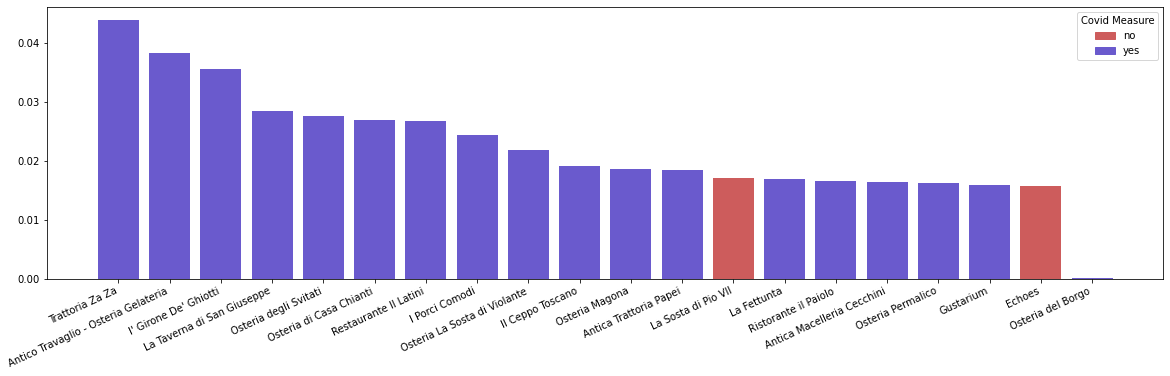

In [31]:
plotCentrality(df,centralities, k = 20)

In [19]:
routes[(0,1231)]

[(0, 0, 0),
 (14805, 0, 170),
 (1972, 0, 181),
 (2178, 4, 184),
 (10647, 0, 186),
 (10576, 0, 186),
 (10612, 0, 187),
 (13064, 0, 197),
 (1366, 0, 221),
 (6753, 0, 238),
 (1231, 0, 329)]

#### Geo

In [7]:

with open('../data/clean/allpathsGeo.PICKLE','rb') as f:
    georoutes = pickle.load(f)
    

In [9]:
geocentralities = betwenness(G,georoutes)

100%|██████████████████████████████████████████████████████████████████| 22333895/22333895 [02:04<00:00, 179838.59it/s]


<ipython-input-5-1b3c80d362ae>:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mycolors = [['indianred','slateblue'][df.loc[r,'covidMeasure']] for r in restaurants]


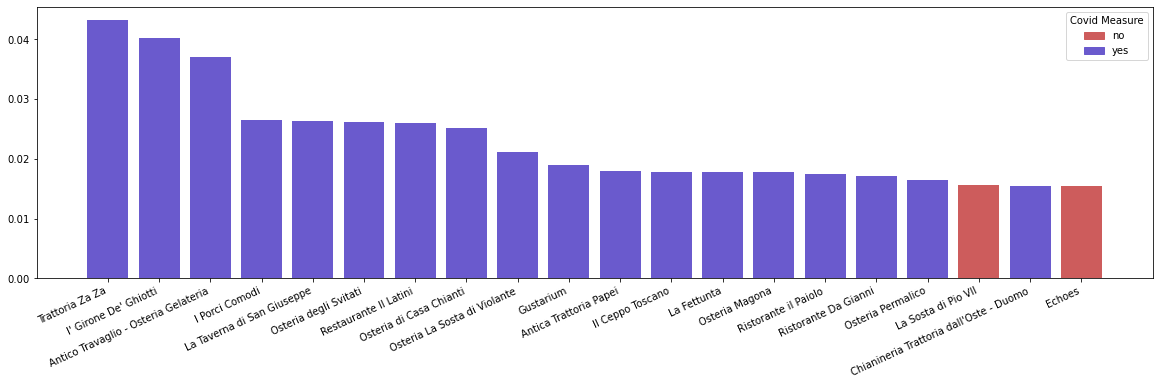

In [10]:
plotCentrality(df,geocentralities, k = 20)

#### DAYS

In [ ]:

with open('../data/clean/allpathsGeo.PICKLE','rb') as f:
    dayroutes = pickle.load(f)

In [ ]:
daycentralities = betwenness(G,routes)

In [ ]:
plotCentrality(df,daycentralities, k = 20)